
Nom : Tsang<br>
Prénom : Gwendal<br>



In [ ]:
import sys
print(sys.version)

3.12.9 | packaged by conda-forge | (main, Feb 14 2025, 08:00:06) [GCC 13.3.0]


On commence par **télécharger 20newsgroups** en utilisant `remove=("headers","footers","quotes")` pour supprimer les métadonnées (en-têtes, pieds de page, citations).
Cela évite que le modèle "triche" (en regardant l'adresse email de l'expéditeur, l'organisation, les en-têtes) et force la classification à se baser davantage sur le contenu.

Par défaut [`fetch_20newsgroups`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) mélange l’ordre des documents (`shuffle=True`). Fixer `random_state=21` rend cet ordre reproductible, ce qui stabilise ensuite la validation croisée et les algorithmes sensibles à l’ordre.

In [ ]:
pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.datasets import fetch_20newsgroups

data_train = fetch_20newsgroups(subset="train", remove=("headers","footers","quotes"), random_state=21)
train_label = data_train.target
data_test  = fetch_20newsgroups(subset="test",  remove=("headers","footers","quotes"), random_state=21)
test_label = data_test.target
len(data_train.data), len(data_test.data), len(test_label)

(11314, 7532, 7532)

Les 20 différentes catégories :

In [ ]:
for i, name in enumerate(data_train.target_names):
    print(i, name)

0 alt.atheism
1 comp.graphics
2 comp.os.ms-windows.misc
3 comp.sys.ibm.pc.hardware
4 comp.sys.mac.hardware
5 comp.windows.x
6 misc.forsale
7 rec.autos
8 rec.motorcycles
9 rec.sport.baseball
10 rec.sport.hockey
11 sci.crypt
12 sci.electronics
13 sci.med
14 sci.space
15 soc.religion.christian
16 talk.politics.guns
17 talk.politics.mideast
18 talk.politics.misc
19 talk.religion.misc


In [ ]:
x_test = data_test.data
x_train = data_train.data
len(x_train), len(x_test)

(11314, 7532)

# **SVM linéaire**


On distingue deux grands types de SVM linéaires : le **Hard margin** SVM et le **Soft margin** SVM.




### SVM **Hard Margin**

Dans le premier, les instances doivent être parfaitement séparables par un hyperplan linéaire.

Les $x_i$ dans la classe $y_i = 1$ doivent satisfaire :
$$\omega^\top x_i + b \ge 1$$

Et les points $x_i$ dans la classe $y_i = -1$ doivent satisfaire :
$$\omega^\top x_i + b \le -1$$

On constate qu'un élément $x_i$ est bien classifié si $y_i$ et $(\omega^\top x_i + b)$ ont le même signe. Ainsi, on peut reformuler ces deux contraintes de manière unifiée :
$$\boxed{\forall i,\quad y_i \cdot (\omega^\top x_i + b) \ge 1}$$


Mais cela suppose que les données soient parfaitement linéairement séparables.

Si ce n'est pas le cas, alors, quel que soit l’hyperplan choisi, il existera au moins un point $x_i$ pour lequel $y_i \cdot (\omega^\top x_i + b) \le 0$ c’est-à-dire au moins un point mal classé (ce qui arrive si $y_i$ et $(\omega^\top x_i + b)$ ont des signes différents), ou situé sur la frontière de décision (ce qui arrive si $y_i \cdot (\omega^\top x_i + b) = 0$).

Formellement, c'est linéairement séparable si

$$\exists (\omega,b)\ \text{tel que}\ \forall i,\ y_i(\omega^\top x_i + b) > 0$$


et non linéairement séparable si :

$$\forall (\omega,b),\ \exists i\ \text{tel que}\ y_i(\omega^\top x_i + b) \le 0$$

### SVM **Soft Margin**

C'est ce pourquoi on utilise un **SVM linéaire soft margin** qui fonctionne même si les données ne sont pas parfaitement linéairement séparables en tolérant des écarts et donc des erreurs de classifications éventuelles.

De manière générale, dans un SVM, il faut maximiser l'espacement entre les deux marges (qui correspondent aux deux hyperplans $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = 1 \}$ et $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = -1 \}$). Mais, avec certaines données non linéairement séparables, il faut trouver un compromis entre la largeur de la marge et les erreurs de classification.

Dans un SVM soft margin, on associe à chaque point $x_i$ une quantité $\xi_i$ qui indique “de combien il manque” pour satisfaire la condition idéale $y_i(\omega^\top x_i + b) \ge 1$. Pour chaque point $x_i$, la quantité $\xi_i$ est donnée par :

$$\xi_i = \max(0, 1 - y_i (\omega^\top x_i + b))$$

Il y a trois cas possibles (bien classé, dans la marge, mal classé) :

* Si le point $x_i$ est bien classé :

$$
y_i (\omega^\top x_i + b) \ge 1
\quad\Rightarrow\quad
\big[1 - y_i (\omega^\top x_i + b)\big] \le 0
\quad\Rightarrow\quad
\xi_i = 0
$$

* Si le point $x_i$ est dans la marge (entre les deux hyperplans) mais correctement classé :

$$
0 < y_i (\omega^\top x_i + b) < 1
\quad\Rightarrow\quad
0 < \xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] < 1
$$

* Si le point $x_i$ est mal classé :

$$
y_i (\omega^\top x_i + b) < 0
\quad\Rightarrow\quad
\xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] > 1
$$

Maintenant, on peut pénaliser le modèle à la fois en fonction du nombre de points du mauvais côté (en comptant à la fois les points dans les marges bien classés et ceux qui sont mal classés) et de l'ampleur des violations (plus la position d'un point s'écarte de sa position attendue, plus la pénalité sur la loss sera forte).

### **Comparaison de [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et de [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)**

Dans `LinearSVC` de Scikitlearn, on peut régler le compromis entre la largeur de la marge et les erreurs sur l’échantillon grâce à l'hyperparamètre $C$.

Si $C$ est grand, on cherche à réduire au maximum ces erreurs quitte à avoir une marge plus petite ; si $C$ est petit, on tolère davantage les violations pour favoriser une marge plus large.

`SGDClassifier` regroupe plusieurs classifieurs linéaires dont les poids sont optimisés par descente de gradients. Lorsqu'on règle `loss='hinge'`, c'est un SVM linéaire.

Dans `SGDClassifier` l'hyperparamètre "alpha" joue un rôle équivalent au paramètre $C$ de `LinearSVC`.




## **Quel optimiseur d'hyperparamètres choisir ?**

On présente ci-dessous trois méthodes pour rechercher les hyperparamètres optimaux :

### 1. **GridSearch**
**[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)** effectue une recherche ***exhaustive*** : il teste *toutes* les combinaisons possibles dans des grilles d'hyperparamètres prédéfinies.
Bien qu'on ait la garantie de trouver l'optimum global dans l'espace discret prédéfini, le temps et le coût computationnel peuvent vite devenir très élevés en fonction de la taille de l'espace des valeurs possibles.

### 2. **RandomizedSearchCV**

Au lieu d’essayer toutes les combinaisons possibles de paramètres,
[`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) choisit ***au hasard*** un certain nombre (prédéfini) de combinaisons de paramètres. Il évalue chacune de ces combinaisons avec une validation croisée. Puis, finalement, il retient la combinaison qui donne les meilleurs résultats. On trouve sur le site de Scikitlearn [un code qui emploie cette méthode](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-plot-grid-search-text-feature-extraction-py) pour trouver les hyperparamètres optimaux d'un classifieur Naive Bayes sur le même dataset qu'ici (20newsgroups).

### 3. **Optuna**
**[`Optuna`](https://pypi.org/project/optuna/)** utilise une recherche ***bayésienne*** (algorithme TPE - Tree-structured Parzen Estimator) en échantillonnant l'espace des hyperparamètres et en privilégiant les régions prometteuses identifiées par les évaluations précédentes. Cela permet d'obtenir de bonnes solutions avec moins d'itérations. C'est pas absolument nécessaire ici mais dans certains cas où les espaces d'hyperparamètres à tester sont de très grande dimension et continus c'est plus rapide et efficace.

# **Méthodologie**

Puisqu'on ne sait pas trop quoi choisir entre [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et  [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), nous allons tester une optimisation des hyperparamètres avec les deux dans la section 3.

Pour que ce soit vraiment comparable, on va essayer de faire vraiment l'équivalent des deux côtés.

Mais avant cela, il faut procéder à une étape de vectorisation.

## **Vectorisation avec TF-IDF**

#### **Suppression des stop-words**

Scikit-learn possède un fichier interne qui contient une liste fixe de mots anglais considérés comme des `stop_words` . Comme ils le font dans les codes proposé sur leur site (par exemple [ce code](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html) ou encore [ce code](https://scikit-learn.org/0.21/auto_examples/text/plot_document_classification_20newsgroups.html)), on enlève les `stop_words` présents dans le corpus. On peut afficher le nombre de ces `stop_words` et les inspecter manuellement avec :

```python
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(len(ENGLISH_STOP_WORDS))
print(list(ENGLISH_STOP_WORDS))
```

Commençons par computer toutes les matrices [TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF) qui vont être utilisées, de manière à éviter de les re-calculer. La cellule qui suit prend quelques minutes à s'executer et prend un certain espace dans la RAM, mais elle permettra de gagner du temps lors des étapes d'optimisation des hyperparamètres juste après.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from itertools import product
import numpy as np

# Valeurs discrètes pour le cache
MAX_FEATURES_VALUES = [10000, 15000, 20000, 25000, 30000]
MAX_DF_VALUES = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def precompute_tfidf(texts_train, texts_test, max_feats, max_df_vals, n_jobs=-1):
    """
    Pré-calcule les matrices TF-IDF pour les 5*6 = 30 combinaisons
    Stocke aussi le vectorizer pour transformer les données de test.
    """
    def fit(mf, mdf):
        vec = TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_features=mf,
            max_df=mdf,
            dtype=np.float32
        )
        X_train = vec.fit_transform(texts_train)
        X_test = vec.transform(texts_test)
        return (mf, mdf), {
            'vectorizer': vec,
            'X_train': X_train,
            'X_test': X_test
        }

    results = Parallel(n_jobs=n_jobs)(
        delayed(fit)(mf, mdf)
        for mf, mdf in product(max_feats, max_df_vals)
    )
    return dict(results)

# Pré-calcul (exécuté une seule fois)
print(f"Pré-calcul de {len(MAX_FEATURES_VALUES) * len(MAX_DF_VALUES)} matrices TF-IDF")
tfidf_cache = precompute_tfidf(
    x_train, x_test,
    MAX_FEATURES_VALUES,
    MAX_DF_VALUES
)
print(f"Cache créé avec {len(tfidf_cache)} entrées.")

Pré-calcul de 30 matrices TF-IDF
Cache créé avec 30 entrées.


## **Précautions méthodologiques**

Les codes pythons qui suivent font une validation croisée. Or, en principe, pour une validation croisée, les vecteurs TF-IDF **doivent être calculés uniquement sur les "plis d'entraînement"** (training folds) et être appliqués sur le "pli de validation" (validation fold) pour éviter toute fuite ([data leakage](https://scikit-learn.org/stable/common_pitfalls.html#how-to-avoid-data-leakage)).


Or, en l'occurence les vecteurs TF-IDF ont été entraînés sur tout `X_train` et dans l'optimisation des hyperparamètres qui suit, on découpe `X_train` en folds.


La conséquence est que, dans l'entraînement la validation “voit” indirectement des statistiques globales (IDF + vocabulaire sélectionné via `max_features`).

Ainsi, **il faut prendre les résultats des optimisations qui suivent avec précaution**, car la façon dont on procède risque de gonfler très légèrement les scores.

Mais l'approche par cache est plus économique computationnellement (et donc plus rapide ici). On constatera l'écart de performance avec l'ensemble "test" ultérieurement. Dans une approche rigoureuse, il faudrait computer les 30 combinaisons *pour chaque fold*, et puisque qu'on prend `cv=4` ce serait 4 fois plus long à exécuter :

$$(\text{nb_combinaisons_TF-IDF}) × (\text{nb_folds}) = 30 × 4 = 120 \text{ matrices}$$

In [ ]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import optuna
import time

def create_objective_fast_cached(y, tfidf_cache, cv=4):
    """Réutilisation du cache TF-IDF pré-calculé."""
    def objective(trial):
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        alpha = trial.suggest_float('alpha', 1e-4, 1e-2, log=True)

        # Récupération de la matrice pré-calculée (économie de compute !)
        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = SGDClassifier(
            loss='hinge',
            alpha=alpha,
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )

        # Mesure du temps d'exécution
        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score

    return objective

def run_optuna_fast_cached(y, tfidf_cache, n_trials=30, cv=4):
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
    )
    objective = create_objective_fast_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)
    return study

# Lancement
study_sgd = run_optuna_fast_cached(train_label, tfidf_cache, n_trials=30)

print(f"\n[SGDClassifier] Meilleurs hyperparamètres : {study_sgd.best_params}")
print(f"[SGDClassifier] Meilleur score CV : {study_sgd.best_value:.4f}")
print("\n[Importance des hyperparamètres]")

importances = optuna.importance.get_param_importances(study_sgd)
for param, importance in importances.items():
    print(f"{param} : {importance:.4f}")

[I 2025-12-19 22:10:03,332] A new study created in memory with name: no-name-86713ea5-eea5-4289-b00a-87f287790aa2


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-19 22:10:04,141] Trial 0 finished with value: 0.7229975156279452 and parameters: {'max_features': 15000, 'max_df': 0.7, 'alpha': 0.008706020878304856}. Best is trial 0 with value: 0.7229975156279452.
[I 2025-12-19 22:10:04,803] Trial 1 finished with value: 0.7195505056489591 and parameters: {'max_features': 10000, 'max_df': 0.8, 'alpha': 0.0005404103854647331}. Best is trial 0 with value: 0.7229975156279452.
[I 2025-12-19 22:10:05,122] Trial 2 finished with value: 0.7225553821478194 and parameters: {'max_features': 15000, 'max_df': 1.0, 'alpha': 0.004138040112561018}. Best is trial 0 with value: 0.7229975156279452.
[I 2025-12-19 22:10:05,461] Trial 3 finished with value: 0.730157178155325 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.001096821720752952}. Best is trial 3 with value: 0.730157178155325.
[I 2025-12-19 22:10:05,841] Trial 4 finished with value: 0.7378464696568127 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.000447363617462

/tmp/ipykernel_899/303084656.py:4: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_optimization_history(study_sgd)
/tmp/ipykernel_899/303084656.py:5: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_slice(study_sgd, params=["max_features"])


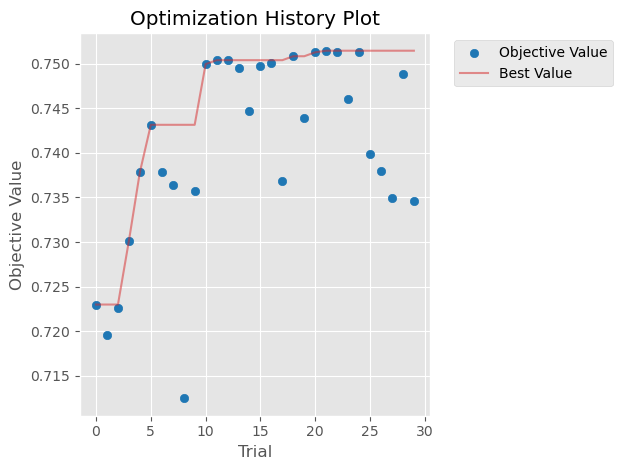

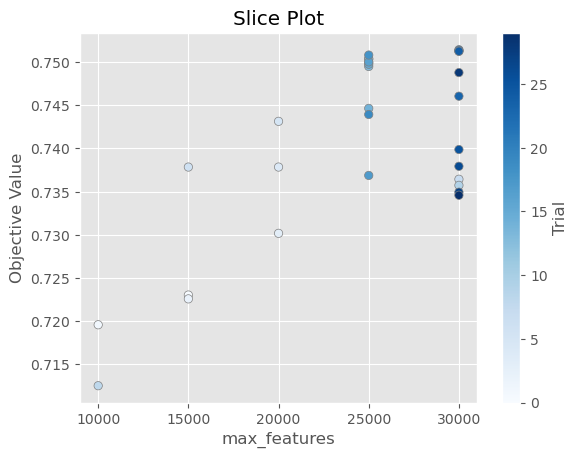

In [ ]:
import optuna.visualization.matplotlib as vis_mpl
import matplotlib.pyplot as plt

vis_mpl.plot_optimization_history(study_sgd)
vis_mpl.plot_slice(study_sgd, params=["max_features"])
plt.show()

### **Tester les performances du modèle `SGDClassifier` sur l'ensemble "test"**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier

best_params = study_sgd.best_params
best_mf = best_params['max_features']
best_mdf = best_params['max_df']
best_alpha = best_params['alpha']

# Retrouver les matrices TF-IDF dans le cache
cached_data = tfidf_cache[(best_mf, best_mdf)]
X_train_transformed = cached_data['X_train']
X_test_transformed = cached_data['X_test']

final_clf = SGDClassifier(
    loss='hinge',
    alpha=best_alpha,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

final_clf.fit(X_train_transformed, train_label)
y_pred = final_clf.predict(X_test_transformed)
final_accuracy = accuracy_score(test_label, y_pred)

print(f"Précision (accuracy) sur le test : {final_accuracy:.4f}")
print(classification_report(test_label, y_pred, target_names=data_test.target_names, digits=3))

Précision (accuracy) sur le test : 0.6904
                          precision    recall  f1-score   support

             alt.atheism      0.541     0.451     0.492       319
           comp.graphics      0.671     0.702     0.686       389
 comp.os.ms-windows.misc      0.631     0.635     0.633       394
comp.sys.ibm.pc.hardware      0.673     0.635     0.654       392
   comp.sys.mac.hardware      0.730     0.717     0.723       385
          comp.windows.x      0.797     0.727     0.760       395
            misc.forsale      0.737     0.777     0.757       390
               rec.autos      0.771     0.697     0.732       396
         rec.motorcycles      0.796     0.754     0.774       398
      rec.sport.baseball      0.818     0.793     0.806       397
        rec.sport.hockey      0.552     0.925     0.691       399
               sci.crypt      0.824     0.710     0.763       396
         sci.electronics      0.646     0.547     0.592       393
                 sci.med      0.7



On va faire la même chose avec `LinearSVC`.

Pour comparer les paramètres de régularisation entre `SGDClassifier` et `LinearSVC`, on peut utiliser la relation (même ordre de grandeur) :

$$
\alpha \approx \frac{1}{n_{\text{samples}} \, C}.
$$

Cela permet de choisir une plage raisonnable pour $C$ à partir d’une plage testée pour $alpha$. Voir le [User Guide de ScikitLearn](https://scikit-learn.org/stable/modules/linear_model.html#comparison-with-the-regularization-parameter-of-svm)

In [ ]:
n_samples = len(x_train)
alpha_min = 1e-4
alpha_max = 1e-2

# Application de la formule
c_max_equivalent = 1 / (n_samples * alpha_min)
c_min_equivalent = 1 / (n_samples * alpha_max)

print(f"Pour alpha={alpha_max} C équivalent ≈ {c_min_equivalent:.5f}")
print(f"Pour alpha={alpha_min} C équivalent ≈ {c_max_equivalent:.5f}")

Pour alpha=0.01 C équivalent ≈ 0.00884
Pour alpha=0.0001 C équivalent ≈ 0.88386


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import optuna
import optuna.visualization.matplotlib as vis_mpl
import matplotlib.pyplot as plt
import time

def create_objective_large_cached(y, tfidf_cache, cv=4):
    def objective(trial):
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        C = trial.suggest_float('C', 0.01, 0.88, log=True)

        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = LinearSVC(
            C=C,
            loss='hinge',
            dual=True,
            max_iter=2000,
            tol=1e-4,
            random_state=42
        )

        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score
    return objective

def run_optuna_large_cached(y, tfidf_cache, n_trials=40, cv=4):
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    objective = create_objective_large_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)
    return study

# Lancement
study_large = run_optuna_large_cached(train_label, tfidf_cache, n_trials=30)

print(f"\n[LinearSVC] Meilleurs hyperparamètres : {study_large.best_params}")
print(f"[LinearSVC] Meilleur score CV : {study_large.best_value:.4f}")
print("\n[Importance des hyperparamètres]")
importances = optuna.importance.get_param_importances(study_large)
for param, importance in importances.items():
    print(f"{param} : {importance:.4f}")

[I 2025-12-19 22:10:18,662] A new study created in memory with name: no-name-be7fdb56-24fc-417b-9869-def28a10b1f0


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:20,289] Trial 0 finished with value: 0.736962640174031 and parameters: {'max_features': 15000, 'max_df': 0.7, 'C': 0.7690824499081822}. Best is trial 0 with value: 0.736962640174031.
[I 2025-12-19 22:10:21,061] Trial 1 finished with value: 0.7112417148016876 and parameters: {'max_features': 10000, 'max_df': 0.8, 'C': 0.05156847114389714}. Best is trial 0 with value: 0.736962640174031.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:22,788] Trial 2 finished with value: 0.7351065482627643 and parameters: {'max_features': 15000, 'max_df': 1.0, 'C': 0.3731767994255017}. Best is trial 0 with value: 0.736962640174031.
[I 2025-12-19 22:10:24,023] Trial 3 finished with value: 0.730422133260137 and parameters: {'max_features': 20000, 'max_df': 0.7, 'C': 0.10262738323403538}. Best is trial 0 with value: 0.736962640174031.
[I 2025-12-19 22:10:24,976] Trial 4 finished with value: 0.7289194293993859 and parameters: {'max_features': 20000, 'max_df': 0.7, 'C': 0.042914019172429936}. Best is trial 0 with value: 0.736962640174031.
[I 2025-12-19 22:10:25,739] Trial 5 finished with value: 0.7281241578558704 and parameters: {'max_features': 20000, 'max_df': 0.9, 'C': 0.024344406960746016}. Best is trial 0 with value: 0.736962640174031.
[I 2025-12-19 22:10:26,360] Trial 6 finished with value: 0.7212299816559448 and parameters: {'max_features': 15000, 'max_df': 0.8, 'C': 0.013291931999695118}. Best is trial 0 with 

/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:28,651] Trial 8 finished with value: 0.7233511849139769 and parameters: {'max_features': 10000, 'max_df': 0.8, 'C': 0.29454801263251296}. Best is trial 0 with value: 0.736962640174031.
[I 2025-12-19 22:10:29,968] Trial 9 finished with value: 0.734841749399906 and parameters: {'max_features': 30000, 'max_df': 1.0, 'C': 0.11187721422183736}. Best is trial 0 with value: 0.736962640174031.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:32,143] Trial 10 finished with value: 0.751457799923304 and parameters: {'max_features': 25000, 'max_df': 0.5, 'C': 0.7678000073407016}. Best is trial 10 with value: 0.751457799923304.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:34,289] Trial 11 finished with value: 0.7491599807609909 and parameters: {'max_features': 25000, 'max_df': 0.5, 'C': 0.5820207477309552}. Best is trial 10 with value: 0.751457799923304.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:36,474] Trial 12 finished with value: 0.750662465883007 and parameters: {'max_features': 25000, 'max_df': 0.5, 'C': 0.8146583758246043}. Best is trial 10 with value: 0.751457799923304.
[I 2025-12-19 22:10:37,997] Trial 13 finished with value: 0.7397911195073453 and parameters: {'max_features': 25000, 'max_df': 0.5, 'C': 0.25334438617022137}. Best is trial 10 with value: 0.751457799923304.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:39,922] Trial 14 finished with value: 0.751546045378663 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.8566971655373805}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:10:41,191] Trial 15 finished with value: 0.7362555203407025 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.19665249838505744}. Best is trial 14 with value: 0.751546045378663.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:42,994] Trial 16 finished with value: 0.7475691564384435 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.47751610537589834}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:10:44,353] Trial 17 finished with value: 0.7356369896950307 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.18583490255620982}. Best is trial 14 with value: 0.751546045378663.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:46,256] Trial 18 finished with value: 0.7509274834846005 and parameters: {'max_features': 25000, 'max_df': 0.9, 'C': 0.8491820915126915}. Best is trial 14 with value: 0.751546045378663.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:47,837] Trial 19 finished with value: 0.7448291100508324 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.40141289385161755}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:10:49,257] Trial 20 finished with value: 0.7366979038079539 and parameters: {'max_features': 30000, 'max_df': 0.5, 'C': 0.15994151622782682}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:10:51,292] Trial 21 finished with value: 0.7512809965286787 and parameters: {'max_features': 25000, 'max_df': 0.9, 'C': 0.8766381824856472}. Best is trial 14 with value: 0.751546045378663.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:53,416] Trial 22 finished with value: 0.7484527046857087 and parameters: {'max_features': 25000, 'max_df': 0.9, 'C': 0.5824785641121216}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:10:55,500] Trial 23 finished with value: 0.7485410751346306 and parameters: {'max_features': 25000, 'max_df': 0.9, 'C': 0.5633663389861733}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:10:56,939] Trial 24 finished with value: 0.7445639987040668 and parameters: {'max_features': 25000, 'max_df': 0.5, 'C': 0.3706258351931301}. Best is trial 14 with value: 0.751546045378663.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:10:58,369] Trial 25 finished with value: 0.7268865340934942 and parameters: {'max_features': 10000, 'max_df': 0.9, 'C': 0.7030259212942891}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:10:59,658] Trial 26 finished with value: 0.7407633819358302 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.27141572277420345}. Best is trial 14 with value: 0.751546045378663.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:11:01,370] Trial 27 finished with value: 0.7450941589008166 and parameters: {'max_features': 25000, 'max_df': 0.5, 'C': 0.4462867360484758}. Best is trial 14 with value: 0.751546045378663.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-12-19 22:11:03,465] Trial 28 finished with value: 0.7510159789270853 and parameters: {'max_features': 25000, 'max_df': 0.6, 'C': 0.8542841180694839}. Best is trial 14 with value: 0.751546045378663.
[I 2025-12-19 22:11:04,754] Trial 29 finished with value: 0.738642084932626 and parameters: {'max_features': 15000, 'max_df': 0.7, 'C': 0.6850581407224133}. Best is trial 14 with value: 0.751546045378663.

[LinearSVC] Meilleurs hyperparamètres : {'max_features': 25000, 'max_df': 0.6, 'C': 0.8566971655373805}
[LinearSVC] Meilleur score CV : 0.7515

[Importance des hyperparamètres]
max_features : 0.6980
C : 0.2006
max_df : 0.1014


/tmp/ipykernel_899/2379190173.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_optimization_history(study_large)
/tmp/ipykernel_899/2379190173.py:4: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_slice(study_large, params=["max_features"])


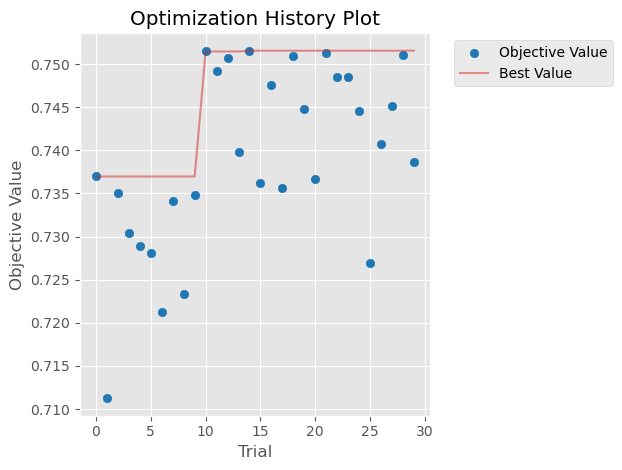

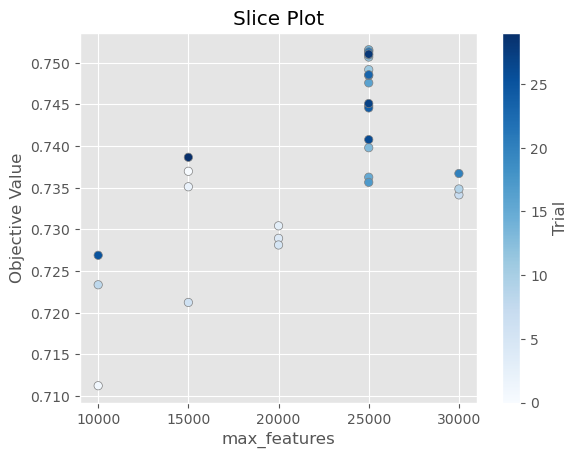

In [ ]:
# Visualisations

vis_mpl.plot_optimization_history(study_large)
vis_mpl.plot_slice(study_large, params=["max_features"])
plt.show()

## **Résultats**

### **Performances**

Le troisième graphique suggère que plus la dimensionalité des vecteurs TF-IDF est grande (plus l'hyperparamètre `max_features` est élevé), plus la performance est élevée, toutes choses égales par ailleurs.
Cependant :
- l'effet peut plafonner (voire se dégrader) au-delà d'une certaine valeur,
- ici le score CV est potentiellement optimiste car la vectorisation TF‑IDF est pré-calculée sur tout le train avant la validation croisée.
La comparaison la plus fiable reste la performance sur l'ensemble de test.



### **Différences entre `LinearSVC` et `SGDClassifier`**

Au global, dans cette optimisation des hyperparamètres, la méthode `LinearSVC` prend un tout petit peu plus de temps que la méthode `SGDClassifier`.  De plus, il semble qu'elle arrive généralement à une performance très très légèrement meilleure.

### **SGDClassifier sur l'ensemble "test"**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier

best_params = study_large.best_params
best_mf = best_params['max_features']
best_mdf = best_params['max_df']
best_C = best_params['C']

# Récupérer les matrices TF-IDF dans le cache
cached_data = tfidf_cache[(best_mf, best_mdf)]
X_train_transformed = cached_data['X_train']
X_test_transformed = cached_data['X_test']

final_clf = LinearSVC(
    C=best_C,
    max_iter=1500,
    tol=1e-4,
    dual=True,
    random_state=42
)

# Tester les performances du modèle sur l'ensemble "test"
final_clf.fit(X_train_transformed, train_label)
y_pred = final_clf.predict(X_test_transformed)
final_accuracy = accuracy_score(test_label, y_pred)

print(f"Précision (accuracy) sur le test : {final_accuracy:.4f}")
print(classification_report(test_label, y_pred, target_names=data_test.target_names, digits=3))

Précision (accuracy) sur le test : 0.6810
                          precision    recall  f1-score   support

             alt.atheism      0.520     0.483     0.501       319
           comp.graphics      0.641     0.712     0.675       389
 comp.os.ms-windows.misc      0.614     0.627     0.621       394
comp.sys.ibm.pc.hardware      0.631     0.640     0.635       392
   comp.sys.mac.hardware      0.719     0.686     0.702       385
          comp.windows.x      0.806     0.694     0.746       395
            misc.forsale      0.748     0.782     0.764       390
               rec.autos      0.723     0.687     0.705       396
         rec.motorcycles      0.746     0.739     0.742       398
      rec.sport.baseball      0.537     0.826     0.651       397
        rec.sport.hockey      0.867     0.867     0.867       399
               sci.crypt      0.833     0.692     0.756       396
         sci.electronics      0.640     0.570     0.603       393
                 sci.med      0.7

Puisqu'on vient de sauvegarder tous les temps d'éxécution, on peut faire une régression pour voir quels sont les hyperparamètres qui influencent le plus le temps d'éxécution.

### **Quel paramètre influence le plus le temps d'éxécution ?**

In [ ]:
pip install polars -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import polars as pl

def analyze_duration_importance(study, features, name):
    """Analyse de l'impact des features sur le temps d'exécution."""
    df = pl.DataFrame([
        t.params | {'duration': t.user_attrs['duration']}
        for t in study.trials if t.state.name == "COMPLETE"
    ])

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df[features], df["duration"])

    importance = sorted(
        zip(features, rf.feature_importances_.tolist()),
        key=lambda x: x[1],
        reverse=True
    )
    print(f"\n Influence des features sur le temps d'exécution avec {name}:")
    for feat, imp in importance:
        print(f"  {feat}: {imp:.4f}")

# Analyse pour les deux études
analyze_duration_importance(study_sgd, ["max_features", "max_df", "alpha"], "SGDClassifier")
analyze_duration_importance(study_large, ["max_features", "max_df", "C"], "LinearSVC")


 Influence des features sur le temps d'exécution avec SGDClassifier:
  alpha: 0.6539
  max_features: 0.3020
  max_df: 0.0441

 Influence des features sur le temps d'exécution avec LinearSVC:
  C: 0.8058
  max_features: 0.1629
  max_df: 0.0313


Ces résultats corroborent certaines de nos expériences dans lesquelles, lorsqu'on lançait un trial `LinearSVC` avec une valeur de $C$ élevée, ou bien cela prenait très longtemps à converger ou bien cela ne convergeait pas.

On peut néanmoins fixer un nombre maximal d'itérations à l'aide du paramètre `max_iter` (mais l'algorithme coupera même si la convergence n'est pas atteinte).

### **Approche hybride : concaténation des features vectors de TF-IDF à des embeddings statiques Word2vec**

### Associer à chaque document $X_i$ un "vecteur moyen" Word2Vec

Soient $w_1, w_2, \dots, w_N$ tous les mots qui apparaissent dans un document $X_i$ (i.e. un texte / un élément de 20newsgroups).

Admettons que pour chaque mot $w_i$, on dispose d'une représentation Word2vec $\mathbf{v}_i \in \mathbb{R}^{300}$. Le vecteur sémantique moyen du document $\mathbf{x}_{\text{w2v}} \in \mathbb{R}^{300}$ est :
$$ \mathbf{x}_{\text{w2v}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{v}_i $$


Pour calculer la moyenne on utilise [`np.mean`](https://numpy.org/devdocs/reference/generated/numpy.mean.html) et pour opérer la concaténation on utilise [`hstack`](https://numpy.org/devdocs/reference/generated/numpy.hstack.html)

In [ ]:
pip install gensim -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gensim.downloader as api

word2vec_model = api.load("word2vec-google-news-300")
vector_size = word2vec_model.vector_size
print(f"Taille des vecteurs : {vector_size}")

Taille des vecteurs : 300


In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score

# Récupération des meilleurs hyperparamètres de l'étude LinearSVC
best_params = study_large.best_params
best_mf = best_params['max_features']
best_mdf = best_params['max_df']
best_C = best_params['C']

print(f"Configuration : max_features={best_mf}, max_df={best_mdf}, C={best_C:.4f}")

# Vectorisation TF-IDF avec les paramètres optimaux
tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=best_mf,
    max_df=best_mdf,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

# Préparation des embeddings Word2Vec (Moyenne des vecteurs par document)
analyze = tfidf.build_analyzer()
v_size = word2vec_model.vector_size

def get_mean_w2v(data_list):
    vectors = []
    for doc in data_list:
        # On extrait les vecteurs pour chaque mot du document présent dans le modèle
        words_vecs = [word2vec_model[w] for w in analyze(doc) if w in word2vec_model]
        if words_vecs:
            vectors.append(np.mean(words_vecs, axis=0))
        else:
            # Si aucun mot n'est connu, on met un vecteur de zéros
            vectors.append(np.zeros(v_size))
    return np.array(vectors)

print("Calcul des moyennes Word2Vec...")
X_train_w2v = normalize(get_mean_w2v(x_train))
X_test_w2v = normalize(get_mean_w2v(x_test))

# Concaténation des features TF-IDF (sparse) et Word2Vec (dense)
X_train_final = hstack([X_train_tfidf, X_train_w2v])
X_test_final = hstack([X_test_tfidf, X_test_w2v])

print(f"Nombre de features TF-IDF : {X_train_tfidf.shape[1]}")
print(f"Nombre de features totales après concaténation : {X_train_final.shape[1]}")

# Entraînement du LinearSVC final
clf_hybrid = LinearSVC(
    C=best_C,
    dual=True,
    max_iter=10000,
    random_state=42
)

clf_hybrid.fit(X_train_final, train_label)
y_pred_hybrid = clf_hybrid.predict(X_test_final)

# Résultats
accuracy_hybrid = accuracy_score(test_label, y_pred_hybrid)
print(f"\nPrécision (Accuracy) du modèle hybride sur le test : {accuracy_hybrid:.4f}")

Configuration : max_features=25000, max_df=0.6, C=0.8567
Calcul des moyennes Word2Vec...
Nombre de features TF-IDF : 25000
Nombre de features totales après concaténation : 25300

Précision (Accuracy) du modèle hybride sur le test : 0.7002


## **Système de vote en combinant trois modèles différents**

`VotingClassifier` de `from sklearn.ensemble`


Il est possible de combiner plusieurs modèles afin d'améliorer la performance sur le jeu de donnée global. C'est par exemple le cas de [ce notebook](https://www.kaggle.com/code/balatmak/text-classification-pipeline-newsgroups20) qui fait :


```python
VotingClassifier(estimators=[
     ('lr', LogisticRegression(C=10000, penalty='l1', multi_class='ovr')),
     ('mb', MultinomialNB()),
     ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log', penalty="elasticnet"))
], voting='soft', n_jobs=-1)
```

Dans ce qui suit, on combine trois modèles :
- un SVM linéaire qui prend des vecteurs TF-IDF niveau des mots (comme ce qu'on a déjà testé précedemment),
- un SVM linéaire qui prend des vecteurs TF-IDF au niveau des caractères,
- Une régression logistique.

In [ ]:
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report


def build_vectorizer(*, analyzer, ngram_range, min_df, max_df, max_features):
    common = dict(
        strip_accents="unicode",
        lowercase=True,
        sublinear_tf=True,
        dtype=np.float32,
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df,
    )
    if analyzer == "word":
        return TfidfVectorizer(**common, analyzer="word", stop_words="english")
    if analyzer == "char_wb":
        return TfidfVectorizer(**common, analyzer="char_wb")
    raise ValueError(f"Unknown analyzer: {analyzer}")


def weighted_vote_proba(probas, weights):
    w = np.asarray(weights, dtype=np.float32)
    w /= w.sum()
    P = np.stack(probas, axis=0).astype(np.float32, copy=False)
    return np.tensordot(w, P, axes=(0, 0))


def two_stage_select_linear_svc(X_fit_text, y_fit, X_tune_text, y_tune, *, cfgs, C_grid, top_k, max_features, random_state):
    baseline_C = 1.0
    scored = []
    for cfg in cfgs:
        vec = build_vectorizer(max_features=max_features, **cfg)
        Xf = vec.fit_transform(X_fit_text)
        Xt = vec.transform(X_tune_text)
        clf = LinearSVC(C=baseline_C, dual="auto", max_iter=2000, random_state=random_state)
        clf.fit(Xf, y_fit)
        acc = accuracy_score(y_tune, clf.predict(Xt))
        scored.append((acc, cfg, Xf, Xt))

    scored.sort(key=lambda t: t[0], reverse=True)
    top = scored[: max(1, top_k)]

    best_acc, best_cfg, best_C = -1.0, top[0][1], baseline_C
    for _, cfg, Xf, Xt in top:
        for C in C_grid:
            clf = LinearSVC(C=float(C), dual="auto", max_iter=2000, random_state=random_state)
            clf.fit(Xf, y_fit)
            acc = accuracy_score(y_tune, clf.predict(Xt))
            if acc > best_acc:
                best_acc, best_cfg, best_C = acc, cfg, float(C)
    return best_cfg, best_C


def two_stage_select_logreg(X_fit_text, y_fit, X_tune_text, y_tune, *, cfgs, C_grid, top_k, max_features, random_state):
    baseline_C = 1.0
    scored = []
    for cfg in cfgs:
        vec = build_vectorizer(max_features=max_features, **cfg)
        Xf = vec.fit_transform(X_fit_text)
        Xt = vec.transform(X_tune_text)

        clf = LogisticRegression(
            solver="saga",
            penalty="l2",
            C=baseline_C,
            max_iter=1500,
            tol=1e-3,
            n_jobs=-1,
            random_state=random_state,
        )
        clf.fit(Xf, y_fit)
        acc = accuracy_score(y_tune, clf.predict(Xt))
        scored.append((acc, cfg, Xf, Xt))

    scored.sort(key=lambda t: t[0], reverse=True)
    top = scored[: max(1, top_k)]

    best_acc, best_cfg, best_C = -1.0, top[0][1], baseline_C
    for _, cfg, Xf, Xt in top:
        for C in C_grid:
            clf = LogisticRegression(
                solver="saga",
                penalty="l2",
                C=float(C),
                max_iter=2000,
                tol=1e-3,
                n_jobs=-1,
                random_state=random_state,
            )
            clf.fit(Xf, y_fit)
            acc = accuracy_score(y_tune, clf.predict(Xt))
            if acc > best_acc:
                best_acc, best_cfg, best_C = acc, cfg, float(C)
    return best_cfg, best_C

Le code python qui suit partitionne l'ensemble `X_train ` en :

* `X_fit`, qui sera utilisé pour l'entraînement initial des modèles candidats.

* `X_cal`, qui sera utilisé pour sélectionner les meilleurs paramètres et calibrer les probabilités du SVM.

* `X_val`, qui sera utilisé pour déterminer les meilleurs poids à donner à chaque modèle (équivalent de ce qu'on appelle aussi parfois `X_dev`)

In [ ]:
from sklearn.model_selection import train_test_split
random_state = 21

x_train, y_train = data_train.data, data_train.target
x_test, test_label = data_test.data, data_test.target

# Split train -> fit (pour les modèles d'entraînement) + val (pour les paramètres des modèles entraînés avec `ensemble`)

X_fit, X_hold, y_fit, y_hold = train_test_split(
    x_train, y_train,
    test_size=0.10,
    random_state=random_state,
    stratify=y_train,
)

# Split holdout -> tune (pour la recherche des hyperparamètres) + val (pour les paramètres des modèles entraînés avec `ensemble`)
X_tune, X_val, y_tune, y_val = train_test_split(
    X_hold, y_hold,
    test_size=0.50,
    random_state=random_state,
    stratify=y_hold,
)

In [ ]:
# SVM linéaire en reprenant plus ou moins les hyperparamètres précedemment trouvés

max_features_word = 250_000

word_svm_cfg = dict(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.85,
)
word_svm_C = 0.5

vec_word = build_vectorizer(max_features=max_features_word, **word_svm_cfg)
Xf_word = vec_word.fit_transform(X_fit)
Xv_word = vec_word.transform(X_val)

word_svm_cal = CalibratedClassifierCV(
    estimator=LinearSVC(C=word_svm_C, dual="auto", max_iter=4000, random_state=random_state),
    cv=3,
    method="sigmoid",
)
word_svm_cal.fit(Xf_word, y_fit)
P_word_val = word_svm_cal.predict_proba(Xv_word)

val_pred_word = P_word_val.argmax(axis=1)
print("Val accuracy | word SVM (calibrated):", accuracy_score(y_val, val_pred_word))

Val accuracy | word SVM (calibrated): 0.7756183745583038


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_subsample(X, y, max_n, *, random_state):
    n = len(y)
    if max_n is None or n <= max_n:
        return X, y  # nothing to subsample

    # must be < n for StratifiedShuffleSplit
    train_n = min(max_n, n - 1)
    if train_n < 2:
        return X, y

    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_n, random_state=random_state)
    idx, _ = next(sss.split(np.zeros(n), y))
    Xs = [X[i] for i in idx]
    ys = y[idx]
    return Xs, ys

X_fit_s, y_fit_s = stratified_subsample(X_fit, y_fit, max_n=4000, random_state=random_state)
X_tune_s, y_tune_s = stratified_subsample(X_tune, y_tune, max_n=1200, random_state=random_state + 1)

max_features_char_search = 250_000
top_k_cfg = 2

char_cfgs = [
    dict(analyzer="char_wb", ngram_range=(3, 5), min_df=2, max_df=0.95),
    dict(analyzer="char_wb", ngram_range=(3, 6), min_df=2, max_df=0.95),
    dict(analyzer="char_wb", ngram_range=(4, 6), min_df=2, max_df=0.95),
]
C_svm = [0.25, 0.5, 1.0, 2.0]

print(f"Char search sizes: fit={len(y_fit_s)}, tune={len(y_tune_s)}")

%time best_char_cfg, best_char_C = two_stage_select_linear_svc(X_fit_s, y_fit_s, X_tune_s, y_tune_s, cfgs=char_cfgs, C_grid=C_svm, top_k=top_k_cfg, max_features=max_features_char_search, random_state=random_state)

print("Meilleurs hyperparamètres pour le SVM basés sur les caractères :", best_char_cfg)
print("Meilleure valeur pour C  :", best_char_C)

Char search sizes: fit=4000, tune=566
CPU times: user 1min 23s, sys: 1.12 s, total: 1min 24s
Wall time: 1min 24s
Meilleurs hyperparamètres pour le SVM basés sur les caractères : {'analyzer': 'char_wb', 'ngram_range': (3, 5), 'min_df': 2, 'max_df': 0.95}
Meilleure valeur pour C  : 1.0


**Remarque** : la recherche sur les caractères est généralement plus longue que sur les mots, car elle génère énormément plus de features.


vous pouvez réduire le temps d'exécution de la cellule en réduisant `max_features_char_search` à 200_000, il semble que cela converge vers le même résultat.

In [ ]:
max_features_char = 250_000
vec_char = build_vectorizer(max_features=max_features_char, **best_char_cfg)
Xf_char = vec_char.fit_transform(X_fit)
Xv_char = vec_char.transform(X_val)

char_svm_cal = CalibratedClassifierCV(
    estimator=LinearSVC(C=best_char_C, dual="auto", max_iter=4000, random_state=random_state),
    cv=3,
    method="sigmoid",
)
char_svm_cal.fit(Xf_char, y_fit)
P_char_val = char_svm_cal.predict_proba(Xv_char)

val_pred_char = P_char_val.argmax(axis=1)
print("Val accuracy | char SVM (calibrated):", accuracy_score(y_val, val_pred_char))

Val accuracy | char SVM (calibrated): 0.7703180212014135


In [ ]:
lr_cfgs = [
    dict(analyzer="word", ngram_range=(1, 1), min_df=1, max_df=0.85),
    dict(analyzer="word", ngram_range=(1, 2), min_df=1, max_df=0.85),
    dict(analyzer="word", ngram_range=(1, 2), min_df=2, max_df=0.85),
]
C_lr = [0.5, 1.0, 2.0, 5.0, 10.0]
top_k_cfg = 3

print("Rcherche des meilleurs hyperparamètres pour la régression logistique")
best_lr_cfg, best_lr_C = two_stage_select_logreg(
    X_fit, y_fit, X_tune, y_tune,
    cfgs=lr_cfgs,
    C_grid=C_lr,
    top_k=top_k_cfg,
    max_features=max_features_word,
    random_state=random_state,
)
print("Best LR cfg:", best_lr_cfg)
print("Best LR C  :", best_lr_C)

Searching best WORD LogisticRegression (holdout tuning)...
Best LR cfg: {'analyzer': 'word', 'ngram_range': (1, 2), 'min_df': 1, 'max_df': 0.85}
Best LR C  : 2.0


In [ ]:
# Entraînement de la régression logistique sur X_fit et évaluation sur X_val
vec_lr = build_vectorizer(max_features=max_features_word, **best_lr_cfg)
Xf_lr = vec_lr.fit_transform(X_fit)
Xv_lr = vec_lr.transform(X_val)

lr = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=best_lr_C,
    max_iter=2500,
    tol=1e-3,
    n_jobs=-1,
    random_state=random_state,
)
lr.fit(Xf_lr, y_fit)
P_lr_val = lr.predict_proba(Xv_lr)

val_pred_lr = P_lr_val.argmax(axis=1)
print("Val accuracy | word LR:", accuracy_score(y_val, val_pred_lr))

# Tune ensemble weights on X_val
candidates = [1, 2, 3, 4]
best_w, best_acc = (1, 1, 1), -1.0
for w in itertools.product(candidates, repeat=3):
    P = weighted_vote_proba([P_word_val, P_char_val, P_lr_val], w)
    acc = accuracy_score(y_val, P.argmax(axis=1))
    if acc > best_acc:
        best_acc, best_w = acc, w

print("\nRésultats (wordSVM, charSVM, wordLR):", best_w)
print("Val accuracy (ensemble):", best_acc)

print("\nRéajustement des modèles finaux sur l'ensemble d'apprentissage complet...")

# Word SVM final
final_vec_word = build_vectorizer(max_features=max_features_word, **word_svm_cfg)
Xtr_word = final_vec_word.fit_transform(x_train)
Xte_word = final_vec_word.transform(x_test)
final_word_cal = CalibratedClassifierCV(
    estimator=LinearSVC(C=word_svm_C, dual="auto", max_iter=6000, random_state=random_state),
    cv=3,
    method="sigmoid",
)
final_word_cal.fit(Xtr_word, y_train)
P_word_test = final_word_cal.predict_proba(Xte_word)

# Char SVM final
final_vec_char = build_vectorizer(max_features=max_features_char, **best_char_cfg)
Xtr_char = final_vec_char.fit_transform(x_train)
Xte_char = final_vec_char.transform(x_test)
final_char_cal = CalibratedClassifierCV(
    estimator=LinearSVC(C=best_char_C, dual="auto", max_iter=6000, random_state=random_state),
    cv=3,
    method="sigmoid",
)
final_char_cal.fit(Xtr_char, y_train)
P_char_test = final_char_cal.predict_proba(Xte_char)

# LR final
final_vec_lr = build_vectorizer(max_features=max_features_word, **best_lr_cfg)
Xtr_lr = final_vec_lr.fit_transform(x_train)
Xte_lr = final_vec_lr.transform(x_test)
final_lr = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=best_lr_C,
    max_iter=3000,
    tol=1e-3,
    n_jobs=-1,
    random_state=random_state,
)
final_lr.fit(Xtr_lr, y_train)
P_lr_test = final_lr.predict_proba(Xte_lr)

# Ensemble on test
P_ens_test = weighted_vote_proba([P_word_test, P_char_test, P_lr_test], best_w)
test_pred = P_ens_test.argmax(axis=1)

acc = accuracy_score(test_label, test_pred)
f1m = f1_score(test_label, test_pred, average="macro")

print("\nTEST RESULTS")
print("Accuracy :", acc)
print("Macro F1 :", f1m)
print("\nClassification report:\n")
print(classification_report(test_label, test_pred, target_names=data_test.target_names))

Val accuracy | word LR: 0.7544169611307421

Résultats (wordSVM, charSVM, wordLR): (2, 4, 3)
Val accuracy (ensemble): 0.7826855123674912

Réajustement des modèles finaux sur l'ensemble d'apprentissage complet...

TEST RESULTS
Accuracy : 0.7226500265533723
Macro F1 : 0.7103817261286518

Classification report:

                          precision    recall  f1-score   support

             alt.atheism       0.57      0.53      0.55       319
           comp.graphics       0.66      0.74      0.70       389
 comp.os.ms-windows.misc       0.70      0.64      0.67       394
comp.sys.ibm.pc.hardware       0.72      0.67      0.69       392
   comp.sys.mac.hardware       0.77      0.72      0.74       385
          comp.windows.x       0.86      0.74      0.79       395
            misc.forsale       0.81      0.81      0.81       390
               rec.autos       0.52      0.79      0.63       396
         rec.motorcycles       0.80      0.80      0.80       398
      rec.sport.baseball     

### **Pistes expérimentales : retirer certains éléments ? Fusionner certaines catégories ?**

##### **Sur la catégorie `talk.religion.misc`**

Il semble que certaines catégories qui finissent par “misc” soient particulièrement difficiles à classer. [Un article de blog](https://galileo.ai/blog/improving-your-ml-datasets-with-galileo-part-1) montre par exemple que `talk.religion.misc` est fréquemment confondue avec `alt.atheism` et `soc.religion.christian` même par des gros modèles ([exemple](https://github.com/vggls/text_classification_fetch_20newsgroups/blob/main/nlp_ntbk_(fetch_20newsgroups_classification).ipynb)). Dans nos tests avec SVM comme dans beaucoup [d'autres proposés sur internet](https://www.kaggle.com/code/balatmak/text-classification-pipeline-newsgroups20), c'est la catégorie sur laquelle il y a les pires performances.


Il semble que c'est parce que la classe `talk.religion.misc` chevauche les catégories ` alt.atheism` et `soc.religion.christian` . Certains proposent [une version "arrangée" du dataset 20newsgroups](https://huggingface.co/datasets/galileo-ai/20_Newsgroups_Fixed) qui enlève les éléments confusants et ambigus afin de réduire le chevauchement inter-catégories.


##### **Sur la catégorie `comp.os.ms-windows.misc`**


Dans [un code qui vise à faire un clustering](https://scikit-learn.ru/1.4/auto_examples/bicluster/plot_bicluster_newsgroups.html#:~:text=Vectorizing,measure%3A%200.3015) proposé sur le site de Scikitlearn, ils excluent la catégorie `comp.os.ms-windows.misc`.

Dans ce qui suit, on retire deux catégories (`comp.os.ms-windows.misc` et `talk.religion.misc` pour voir si cela améliore les performances.


In [2]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
]

data_train = fetch_20newsgroups(categories=categories, subset="train", remove=("headers","footers","quotes"), random_state=21)
train_label = data_train.target


data_test  = fetch_20newsgroups(categories=categories, subset="test",  remove=("headers","footers","quotes"), random_state=21)
test_label = data_test.target

np.unique(test_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


train_label_filtered = data_train.target
test_label_filtered = data_test.target

from sklearn.pipeline import Pipeline

pipeline_filtered = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=50000)),
    ('clf', LinearSVC(loss='hinge', C=0.4, dual=True, max_iter=1500, random_state=42))
])

print("Entraînement sur le dataset filtré : 18 catégories")
pipeline_filtered.fit(data_train.data, train_label_filtered)
acc = pipeline_filtered.score(data_test.data, test_label_filtered)

print(f"Accuracy sur le dataset filtré : {acc:.4f}")

Entraînement sur le dataset filtré : 18 catégories
Accuracy sur le dataset filtré : 0.7266


Sur cette expérimentation, on n'a pas fait les choses très proprement. Il aurait fallu **comparer** la performance de nombreux modèles sur le dataset original _vs_ sur le dataset réduit pour pouvoir généraliser vraiment.

De manière similaire il aurait été intéressant de relançer l'intégralité des modèles de ce notebook en utilisant de nombreux seeds différents, mais cela prend du temps.